## Evaluation Results

In [1]:
from utils.database import *
from utils.files import *
from tqdm import tqdm
from bson import ObjectId
import pandas as pd 
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_from_disk, Dataset, ClassLabel, Value, Features
from huggingface_hub import InferenceClient
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from utils.preprocessing import *
from utils.accelerators import *
from utils.multithreading import *
from utils.database import *
from utils.model import *
from utils.files import *
from datasets import Dataset
from tqdm import tqdm
import statistics
import hashlib
import random
import time
import math
import re

/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Class Name to ID Mappings

In [2]:
id_to_class = {0: "other", 1: "cannabis", 2: "energie", 3: "kinder"}
class_to_id = {"other": 0, "cannabis": 1, "energie": 2, "kinder": 3}

### Load Dataset

In [3]:
MAX_CONTENT_LENGTH = 384
file_path = f"../data/tmp/processed_dataset_multiclass_chunkified_{MAX_CONTENT_LENGTH}_preds"
dataset = load_from_disk(file_path)

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'token_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'chunk_id', 'url_path', 'input_ids', 'attention_mask', 'probas', 'preds'],
        num_rows: 15828
    })
    test: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'token_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'chunk_id', 'url_path', 'input_ids', 'attention_mask', 'probas', 'preds'],
        num_rows: 816025
    })
    valid: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'token_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'chunk_id', 'url_path', 'input

In [5]:
dataset = dataset["test"]

## Merge Chunk Level Predictions

**Remove duplicates:**

In [6]:
# seen_urls = set()
# dataset = dataset.filter(lambda example: example['view_url'] not in seen_urls and not seen_urls.add(example['view_url']), num_proc=16)

**Group chunks per webpage:**

In [7]:
# Group dataset examples by URL, with a fallback to domain
grouped_dataset = {}
for example in tqdm(dataset):
    url = example.get("view_url") or example.get("domain")
    example_filtered = {k: example[k] for k in ["text", "domain", "probas", "preds", "label", "category", "annotation_type", "lang"]}
    grouped_dataset.setdefault(url, []).append(example_filtered)

  0%|          | 0/816025 [00:00<?, ?it/s]

100%|██████████| 816025/816025 [07:51<00:00, 1729.29it/s]


In [8]:
len(list(grouped_dataset.keys()))

142481

In [9]:
list(grouped_dataset.keys())[0:5]

['www.google.com/',
 'email.t-online.de/em#f=INBOX&m=14788888321797910&method=showReadmail',
 'surveyd.bilendi.com/survey/selfserve/53b/2306124?list=1&ID=247646250822832&t=2&r=2#?',
 'surveyd.bilendi.com/survey/selfserve/53b/2306124#$',
 'surveyd.bilendi.com/survey/selfserve/53b/2306124#&']

In [10]:
#list(grouped_dataset.values())[100][0]

In [11]:
list(grouped_dataset.values())[0][0]

{'text': 'Klicke hier , wenn du nach einigen Sekunden nicht automatisch weitergeleitet wirst',
 'domain': 'google.com',
 'probas': [0.999695897102356,
  3.389493940630928e-05,
  0.00020047806901857257,
  6.981330807320774e-05],
 'preds': 0,
 'label': 0,
 'category': 'other',
 'annotation_type': 'domain_discarded',
 'lang': 'de'}

## Extract Label

In [12]:
# Extract labels
labels_for_url = []
for url, chunks in grouped_dataset.items():
    preds = [chunk["label"] for chunk in chunks]
    labels_for_url.append(max(preds))

## Predictions on Chunk Level

In [13]:
preds = dataset["preds"]
labels = dataset["label"]

In [14]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_frequencies(labels, preds, id_to_class):
    """Plot class frequencies for both true labels and predictions using class names."""
    
    # Count the frequencies of each class in labels and predictions
    label_freq = Counter(labels)
    pred_freq = Counter(preds)

    # Get a sorted list of all unique classes across both labels and preds for consistent plotting
    all_classes = sorted(set(labels) | set(preds), key=lambda x: id_to_class.get(x, 'Unknown Class'))

    # Prepare data for plotting with class names instead of IDs
    label_counts = [label_freq.get(cls, 0) for cls in all_classes]
    pred_counts = [pred_freq.get(cls, 0) for cls in all_classes]
    class_labels = [id_to_class.get(cls, 'Unknown Class') for cls in all_classes]

    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 5))
    bar_width = 0.30  # width of bars

    index = range(len(all_classes))
    bars1 = ax.bar(index, label_counts, bar_width, label='True Labels')
    bars2 = ax.bar([p + bar_width for p in index], pred_counts, bar_width, label='Predictions')

    # Annotate each bar with the frequency value
    for bars in (bars1, bars2):
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

    ax.set_xlabel('Class')
    ax.set_ylabel('Frequency')
    ax.set_title('Class Frequencies in Labels and Predictions')
    ax.set_xticks([p + bar_width / 2 for p in index])
    ax.set_xticklabels(class_labels, rotation=45, ha="right")  # rotated for better visibility if names are long
    ax.legend()

    plt.tight_layout()  # Adjust layout to make room for tick label rotation
    plt.show()

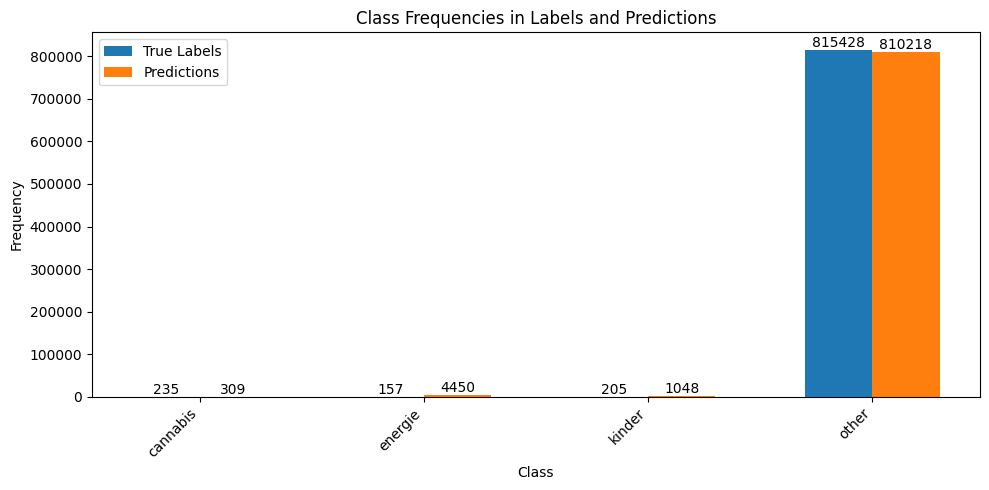

In [15]:
plot_class_frequencies(labels, preds, id_to_class)

In [16]:
def compute_metrics(labels, preds, average='micro'):
    """Compute classification metrics: accuracy, precision, recall, and F1 score."""
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average=average)
    recall = recall_score(labels, preds, average=average)
    f1 = f1_score(labels, preds, average=average)
    
    return accuracy, precision, recall, f1

    
def print_metrics(labels, preds, average='micro'):
    """Print classification metrics: accuracy, precision, recall, and F1 score."""
    accuracy, precision, recall, f1 = compute_metrics(labels, preds, average=average)

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

In [17]:
print_metrics(labels, preds)

Accuracy: 99.34%
Precision: 0.99
Recall: 0.99
F1 Score: 0.99


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(labels, preds, id_to_class):
    """Plot a confusion matrix with class names using seaborn."""
    
    # Generate the confusion matrix
    cm = confusion_matrix(labels, preds)
    
    # Create a list of class names in the order they appear in the id_to_class dictionary
    class_names = [id_to_class[i] for i in sorted(id_to_class.keys())]

    # Create and display a seaborn heatmap with annotations
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=True, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

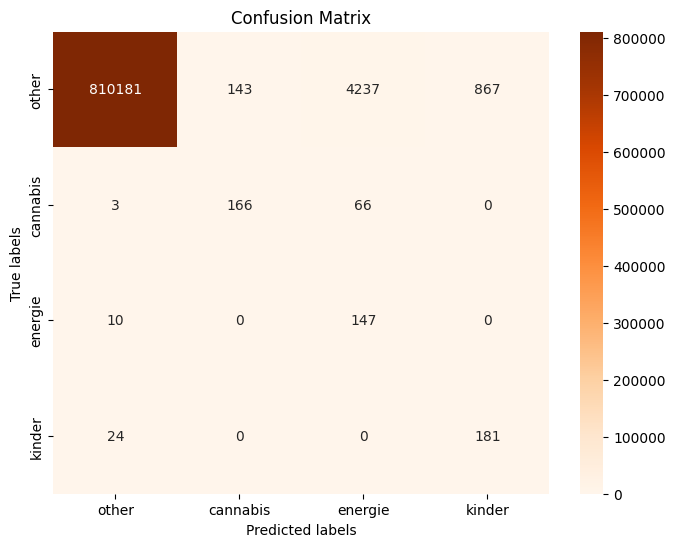

In [19]:
plot_confusion_matrix(labels, preds, id_to_class)

## Predictions on Page Level
Classifying the entire document as in-class if at least one chunk of the document is identified as policy relevant.

In [20]:
def majority_voting(answers):
    """Apply majority voting to a list of arbitrary classification answers."""
    count = Counter(answers)
    most_common = count.most_common()  # Get all common answers sorted by frequency

    if not most_common:
        return 0 # Handle empty input scenario

    # Check for ties at the highest count
    max_votes = most_common[0][1]
    tied_classes = [cls for cls, votes in most_common if votes == max_votes]

    if len(tied_classes) > 1:
        return max(tied_classes)  # Return the maximum class label in case of a tie
    return tied_classes[0]  # Return the class with the most votes

majority_voting([1, 1, 2, 2, 2, 3])

2

In [21]:
prediction_for_url_max = []

# It is kinda nuts that max() works best but the intuition is that most chunks are other and as soon there is anything higher than other (class label 0) it is always related to that policy
for url, chunks in grouped_dataset.items():
    preds = [chunk["preds"] for chunk in chunks]
    #preds = preds if len(preds) > 0 else [0]
    pred = majority_voting([pred for pred in preds if pred > 0]) if max(preds) > 0 else 0
    prediction_for_url_max.append(pred)

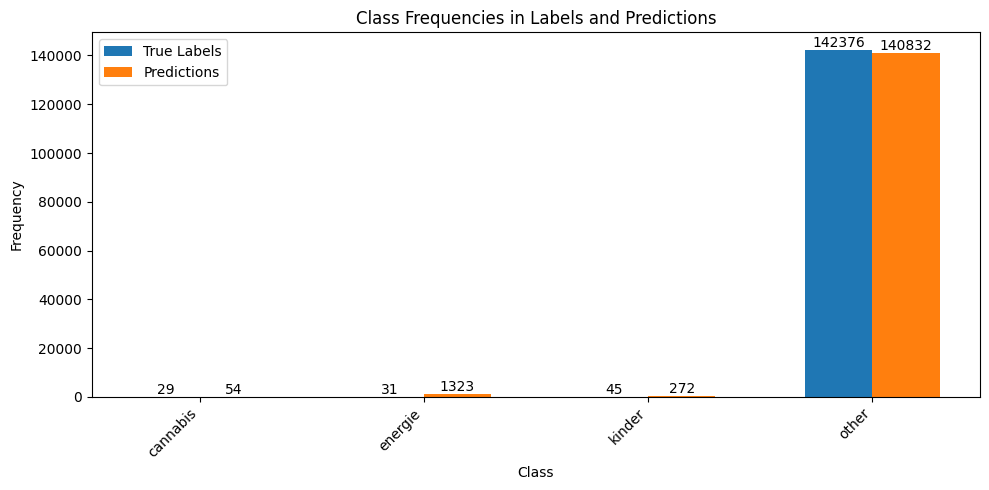

In [22]:
plot_class_frequencies(labels_for_url, prediction_for_url_max, id_to_class)

In [23]:
print_metrics(labels_for_url, prediction_for_url_max)

Accuracy: 98.88%
Precision: 0.99
Recall: 0.99
F1 Score: 0.99


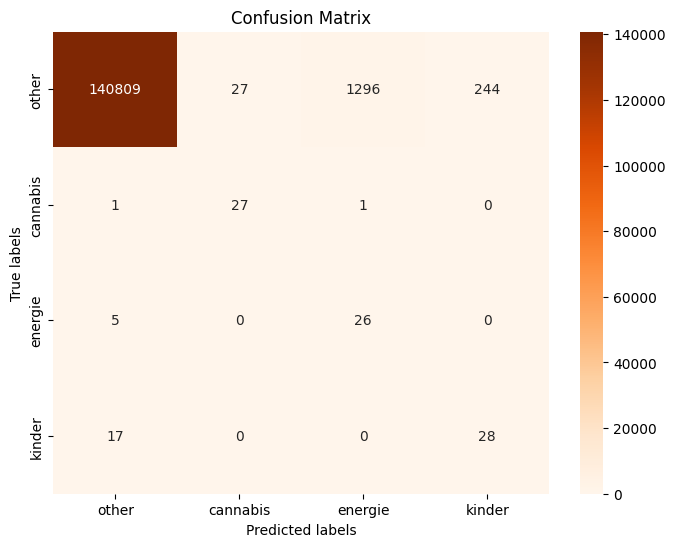

In [24]:
plot_confusion_matrix(labels_for_url, prediction_for_url_max, id_to_class)

**Most misclassified domains:**

In [25]:
from collections import Counter
from tabulate import tabulate

urls = list(grouped_dataset.keys())
chunks = list(grouped_dataset.values())
misclassified_domains = Counter()  # Counter to track misclassified chunks by domain

for id_x, (label, prediction) in enumerate(zip(labels_for_url, prediction_for_url_max)):
    if label != prediction:
        # Process each chunk in the misclassified example
        for chunk_id, chunk in enumerate(chunks[id_x]):
            if 'domain' in chunk:
                # Increment the count for the domain of this misclassified chunk
                misclassified_domains[chunk['domain']] += 1

# Sorting domain data by misclassification count, descending
domain_data = sorted(misclassified_domains.items(), key=lambda x: x[1], reverse=True)

# Formatting the output using tabulate
headers = ['Domain', 'Misclassified Chunks Count']
tabulate(domain_data[:25], headers=headers, tablefmt='html')


Domain,Misclassified Chunks Count
bing.com,432
baywa-re.de,325
chip.de,311
gehalt.de,288
check24.de,269
welt.de,250
trustpilot.com,241
waz.de,225
otto.de,217
t-online.de,212


**Examples of misclassified webpages:**

In [26]:
from tabulate import tabulate

urls = list(grouped_dataset.keys())
chunks = list(grouped_dataset.values())
table_data = []  # List to store all row data for tabulation

for id_x, (label, prediction) in enumerate(zip(labels_for_url, prediction_for_url_max)):
    if label != prediction:
        # Display only up to n chunks, each with detailed information
        for chunk_id, chunk in enumerate(chunks[id_x][:25]):
            preds = chunk['preds']
            text = chunk['text']
            token_count = len(text.split(" "))

            # Limiting text output to the first 50 and last 50 tokens
            text_preview = (text[:50] + '...' + text[-50:]) if len(text) > 100 else text

            # Append each chunk as a separate row in the table
            table_data.append([
                id_x + 1,  # Example ID
                urls[id_x][:250],
                id_to_class[label],
                id_to_class[prediction],
                chunk_id + 1,
                preds,
                token_count,
                text
            ])

        # Break the loop 
        if len(table_data) >= 500: 
            break

# Formatting the output using tabulate
headers = ['Example ID', 'URL', 'Label', 'Prediction', 'Chunk ID', 'Predictions', 'Token Count', 'Text Preview']
display(tabulate(table_data, headers=headers, tablefmt='html', maxcolwidths=[5, 10, 5,  5, 5, 5, 5, 45]))


Example ID,URL,Label,Prediction,Chunk ID,Predictions,Token Count,Text Preview
127,arbeitsage ntur.de/,other,kinde r,1,3,208,"zu den Hauptinhalten springen Gebärdensprache Leichte Sprache Deutsch Hauptnavigation Suche Anmelden Menü Startseite aktuelle Seite: Privatpersonen Willkommen, wie können wir Sie weiterbringen? Privatpersonen Unternehmen Institutionen Weitere Verbesserungen beim Bürgergeld Für Kundinnen und Kunden der Jobcenter gelten ab 1. Juli 2023 neue Regelungen. Arbeitslos und Arbeit finden Jobsuche Arbeitsuchend/ arbeitslos melden Arbeitslosengeld Bürgergeld Kurzarbeitergeld Jobsuche über Personalvermittlung Existenzgründung Schule, Ausbildung und Studium Dein Weg in den Beruf Dein Weg zum Studium Check-U – Das Erkundungstool Betriebliche Ausbildungsplätze Schulische Ausbildungsplätze Duale Studienplätze Studiengänge Berufsberatung Familie und Kinder Kindergeld ab Geburt beantragen Kindergeld ab 18 beantragen Kinderzuschlag beantragen Auszahlungstermine anzeigen Veränderungen mitteilen Menschen mit Behinderungen Berufliche Rehabilitation Spezielle Hilfe und Unterstützung Persönliche Beratung Karriere und Weiterbildung Beruflich weiterbilden Beruf wechseln Wiedereinstieg in den Beruf New Plan – das Erkundungstool Kurse finden Für Menschen aus dem Ausland Deutsch lernen Jobs und Praktika in Deutschland finden Anerkennung von Abschluss und Zeugnis Arbeit für Fachkräfte aus dem Ausland Zulassung zum Arbeitsmarkt Ihre Dienststelle vor Ort Wir sind für Sie da. Kommen Sie persönlich bei uns vorbei oder kontaktieren Sie uns. Dienststelle finden Kontaktieren Sie uns direkt Gerne helfen wir Ihnen persönlich weiter. Kontakt Anregungen und Kritik Downloads Die Bundesagentur für Arbeit bietet Ihnen für verschiedene Themenbereiche Materialien zum Download an. Die wichtigsten finden Sie hier"
127,arbeitsage ntur.de/,other,kinde r,2,0,145,". Dienststelle finden Kontaktieren Sie uns direkt Gerne helfen wir Ihnen persönlich weiter. Kontakt Anregungen und Kritik Downloads Die Bundesagentur für Arbeit bietet Ihnen für verschiedene Themenbereiche Materialien zum Download an. Die wichtigsten finden Sie hier. Download- Center Aktuelle Informationen Erkennbare Auswirkungen der schwachen Wirtschaftsentwicklung BA legt aktuelle Zahlen zum Arbeitsmarkt vor Warnung vor Phishing-Mails mit Logo der Jobcenter Angreifer tarnen sich als Jobcenter, um persönliche Daten zu erlangen Finden Sie Veranstaltungen in Ihrer Nähe Veranstaltungen suchen Über uns Informieren Sie sich über Ziele, Aufbau, Ansprechpartner und die Veröffentlichungen der Bundesagentur für Arbeit. Karriere bei der Bundesagentur Ob Ausbildung, Studium, Traineeprogramm oder Direkteinstieg – starten Sie bei uns Ihre Karriere! Presse Hier finden Sie aktuelle Presseinformationen und den Kontakt zu unserem Presseteam. Statistik Unsere Statistiken, Analysen und Berichte geben Ihnen Aufschluss über den Arbeitsmarkt. © Bundesagentur für Arbeit 2023 Impressum Information & Hilfe Datenschutz Rechtliche Hinweise Erklärung zur Barrierefreiheit Barrieren melden"
127,arbeitsage ntur.de/,other,kinde r,3,3,208,"zu den Hauptinhalten springen Gebärdensprache Leichte Sprache Deutsch Hauptnavigation Suche Anmelden Menü Startseite aktuelle Seite: Privatpersonen Willkommen, wie können wir Sie weiterbringen? Privatpersonen Unternehmen Institutionen Weitere Verbesserungen beim Bürgergeld Für Kundinnen und Kunden der Jobcenter gelten ab 1. Juli 2023 neue Regelungen. Arbeitslos und Arbeit finden Jobsuche Arbeitsuchend/ arbeitslos melden Arbeitslosengeld Bürgergeld Kurzarbeitergeld Jobsuche über Personalvermittlung Existenzgründung Schule, Ausbildung und Studium Dein Weg in den Beruf Dein Weg zum Studium Check-U – Das Erkundungstool Betriebliche Ausbildungsplätze Schulische Ausbildungsplätze Duale Studienplätze Studiengänge Berufsberatung Familie und Kinder Kindergeld ab Geburt beantragen Kindergeld ab 18 beantragen Kinderzuschlag beantragen Auszahlungstermine anzeigen Veränderungen mitteilen Menschen mit Beh

## Per Category

In [27]:
categories = []

for url, chunks in grouped_dataset.items():
    category = [chunk["category"] for chunk in chunks]
    categories.append(category[0])
    
print(categories[:5])

['other', 'other', 'other', 'other', 'other']


In [28]:
from collections import defaultdict
from tabulate import tabulate

def group_by_attribute(attributes, labels, predictions):
    """Group labels and predictions by a specified attribute."""
    
    grouped_labels = defaultdict(list)
    grouped_predictions = defaultdict(list)

    for attribute, label, prediction in zip(attributes, labels, predictions):
        grouped_labels[attribute].append(label)
        grouped_predictions[attribute].append(prediction)

    return grouped_labels, grouped_predictions

def calculate_attribute_metrics(category_labels, category_predictions, average='micro'):
    """Calculate classification metrics for each category."""
    category_metrics = {}
    for category in category_labels:
        metrics = compute_metrics(category_labels[category], category_predictions[category], average=average)
        category_metrics[category] = metrics
    return category_metrics

from tabulate import tabulate

def print_metrics_table(category_metrics):
    """Print the metrics for each category in a nicely formatted table."""
    
    # Prepare table data: Convert the metrics dictionary into a list of lists
    headers = ['Category', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
    table = []
    for category, metrics in category_metrics.items():
        table.append([category] + list(metrics))
    
    # Print table using tabulate
    display(tabulate(table, headers=headers, tablefmt="html"))

In [29]:
category_labels, category_predictions = group_by_attribute(categories, labels_for_url, prediction_for_url_max)
category_metrics = calculate_attribute_metrics(category_labels, category_predictions, average='micro')
print_metrics_table(category_metrics)

Category,Accuracy,Precision,Recall,F1-Score
other,0.990061,0.990061,0.990061,0.990061
news,0.957528,0.957528,0.957528,0.957528
search,0.992795,0.992795,0.992795,0.992795


## Per Annotation Type

In [30]:
annotation_types = []

for url, chunks in grouped_dataset.items():
    annotation_type = [chunk["annotation_type"] for chunk in chunks]
    annotation_types.append(annotation_type[0])
    
print(annotation_type[:5])

['04.urls-with-title', '04.urls-with-title', '04.urls-with-title', '04.urls-with-title', '04.urls-with-title']


In [31]:
types_labels, types_predictions = group_by_attribute(annotation_types, labels_for_url, prediction_for_url_max)
types_metrics = calculate_attribute_metrics(types_labels, types_predictions, average='micro')
print_metrics_table(types_metrics)

Category,Accuracy,Precision,Recall,F1-Score
domain_discarded,0.991267,0.991267,0.991267,0.991267
09.other,0.979978,0.979978,0.979978,0.979978
07.sm,0.998672,0.998672,0.998672,0.998672
13.searches,0.99726,0.99726,0.99726,0.99726
03.searches,0.990238,0.990238,0.990238,0.990238
01.youtube,0.998656,0.998656,0.998656,0.998656
02.shorts,1,1,1,1
12.surfaced_domains,0.857143,0.857143,0.857143,0.857143
05.fbtw,0.967742,0.967742,0.967742,0.967742
11.keyworded_urls,0.625,0.625,0.625,0.625


## Per Language

In [32]:
langs = []

for url, chunks in grouped_dataset.items():
    lang = [chunk["lang"] for chunk in chunks]
    langs.append(lang[0])
    
print(langs[:5])

['de', 'de', 'de', 'de', 'de']


In [33]:
langs_labels, langs_predictions = group_by_attribute(langs, labels_for_url, prediction_for_url_max)
langs_metrics = calculate_attribute_metrics(langs_labels, langs_predictions, average='micro')
print_metrics_table(langs_metrics)

Category,Accuracy,Precision,Recall,F1-Score
de,0.984313,0.984313,0.984313,0.984313
en,0.999167,0.999167,0.999167,0.999167
sk,1,1,1,1
ru,0.98513,0.98513,0.98513,0.98513
ro,1,1,1,1
no,1,1,1,1
et,1,1,1,1
cs,1,1,1,1
fr,1,1,1,1
uk,1,1,1,1
